# Project Analysis NoteBook
## Data Input

The datasets used in this project are available from ['The Cancer Genome Atlas' (TCGA)](www.http://cancergenome.nih.gov/) consortium.  Clinical and RNA-seq gene count data sets can be downloaded via a provided data portal, or using an R package called [TCGA2STAT](https://cran.r-project.org/web/packages/TCGA2STAT/index.html).  The R script used to download the data sets for this project are available in the local repository for this project ([GitHub link](https://github.com/CCThompson82/Prostate_metastasis/tree/master/Dataset_setup)).  If run locally, two [feather](https://github.com/wesm/feather) files will be written to the working directory, which will be read and imported with the python scripts below.

In [1]:
%run -i Dataset_cleanup/arrange_DF.py

Clinical data set imported!
Features: 22 
Patients: 499


Gene Counts data set imported!
Features: 20502 
Patients: 497


Transforming gene counts to transcript per million (TPM)

Transformation Successful!

497 Gene count estimate profiles have been transformed from gene counts to transcripts per million reads (TPM)


## Data Exploration
### Clinical Information - including metastasis label
There is missing clinical data in many of the features, including what will become the outcome label ('pathologyNstage' - metastasis state).  The series **'y_all'** is the full list of pathologyNstage, where 'n1' represents metastasis, and 'n0' represents no metastasis observed to date.  Some observations have no metastasis state recorded and are represented by NaN in y_all.  These are removed for the trimmed **'y'** series.  

In [2]:
print("Total observations in original dataset:",clinical.shape[0])

not_labeled = y_all[y_all.isnull()] 
y = y_all[y_all.notnull()]

print("\nObservations with metastasis label:",y.shape[0])
print("Unlabeled observations (removed:)",not_labeled.shape[0])


Total observations in original dataset: 499

Observations with metastasis label: 426
Unlabeled observations (removed:) 73


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

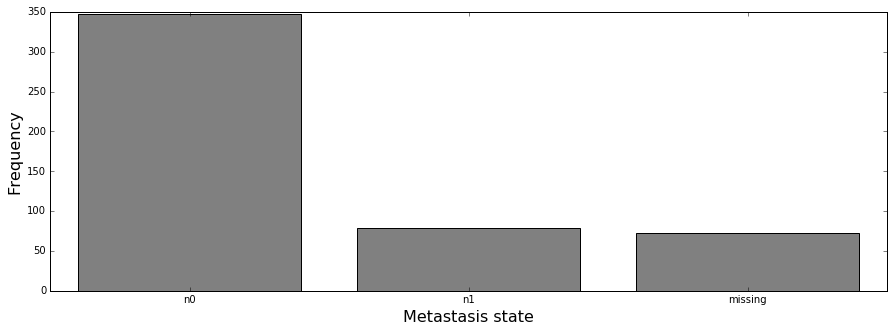

In [4]:
D = (('n0', y[y =='n0'].shape[0]), 
     ('n1', y[y =='n1'].shape[0]), 
     ('missing' , len(not_labeled)))
exp_fig = plt.figure(figsize=(15,5))
A = exp_fig.add_subplot(1,1,1)
ind = A.bar(range(0,3), height= [D[0][1], D[1][1], D[2][1]], align='center', color = 'grey')
A.set_xticks(range(0,3))
A.set_ylabel('Frequency', fontsize=16)
A.set_xlabel('Metastasis state', fontsize=16)
A.set_xticklabels([D[0][0], D[1][0], D[2][0]])  #Must be a better way to do this...
ep = plt.show

#### Gene Activation (Gene counts) Dataset
The starting dataset, **'X_all'**, includes the transformed transcript per million (TPM) estimates for all RNA-seq profiles.  However some of the observations in this set do not have corresponding y_labels, as the clinical data set contains missing information.

Therefore X_all was trimmed to include only those observations where a finite y label exists, to yield **'X'**.  

In [5]:
"""Limit X to only observations where a target label is present."""
X = X_all.loc[set(y.index).intersection(X_all.index)]  #Only observations that also have a known metastasis state are kept.
y = y.loc[set(X.index).intersection(y.index)]
print("X dimensions:",X.shape,"\ny dimensions:",y.shape)

X dimensions: (424, 20501) 
y dimensions: (424,)


In [6]:
X_no_y = X_all.loc[list(not_labeled.index)]
print("Dimensions of unlabeled dataset:",X_no_y.shape)

Dimensions of unlabeled dataset: (73, 20501)


In [7]:
X.isnull().values.any()

False

### Exploratory Visualization

#### Gleason Score versus Metastasis analysis
The Gleason score is the gold-standard diagnostic test for cancer severity, but is not highly correlative with metastatic disease.  

In [8]:
clinical['gleasonscore'] = pd.to_numeric(clinical['gleasonscore'], errors= 'coerce')
clinical['gleasonscore'].isnull().any()

False

<function matplotlib.pyplot.show>

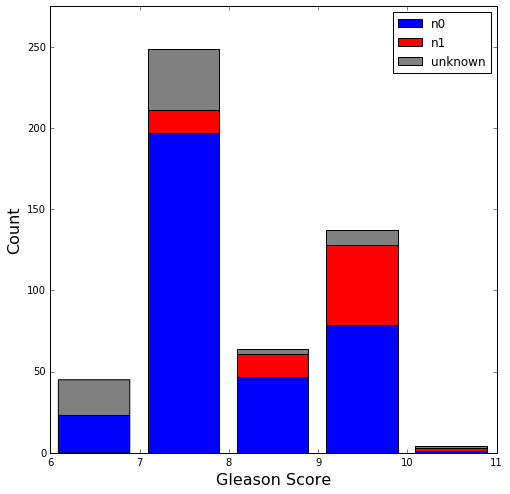

In [9]:
GS_hist = plt.figure(figsize=(8,8))
A = GS_hist.add_subplot(1,1,1)
sub = (('n1', ))

subs = [clinical.loc[y_all[y_all == 'n0'].index]['gleasonscore'],
        clinical.loc[y_all[y_all == 'n1'].index]['gleasonscore'],
        clinical.loc[y_all[y_all.isnull()].index]['gleasonscore']]

bins = [5.99, 6.99, 7.99, 8.99, 9.99, 10.99]
A.hist(subs, bins, label =['n0', 'n1', 'unknown'], color = ['blue','red','grey'], stacked = True)
A.set_ylim(0,275)
A.set_ylabel('Count', fontsize=16)
A.set_xlabel('Gleason Score', fontsize =16)
A.legend()
plt.show

### Algorithms and Techniques
The first step of this process will be feature reduction of the data

### Benchmark 
#### Determine the Null Error / Accuracy Rates for Prediction
As the dataset is unbalanced, knowledge of the null rate - i.e. the performance measure given if a model were to predict the positive label indiscriminantly - is an important benchmark upon which to improve.  

In [10]:
from sklearn.metrics import matthews_corrcoef, fbeta_score, classification_report

In [11]:
y_n1 = ['n1']*len(y)
print('Model predicts indiscriminantly, "n1"')
print('\nNull F beta: ', fbeta_score(y, y_n1, pos_label='n1',beta=2))
print('\nMCC: ',matthews_corrcoef(y, y_n1),"\n")
print(classification_report(y, y_n1, labels = ['n0','n1']))


Model predicts indiscriminantly, "n1"

Null F beta:  0.533783783784

MCC:  0.0 

             precision    recall  f1-score   support

         n0       0.00      0.00      0.00       345
         n1       0.19      1.00      0.31        79

avg / total       0.03      0.19      0.06       424



/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Scale

In [12]:
from sklearn.preprocessing import scale
X_all = pd.DataFrame(scale(X_all), columns = X_all.columns, index = [X_all.index])
X = X_all.loc[X.index]

## Feature Reduction
### Univariate Feature Reduction

SelectKBest is a filtering function that utilizes a scoring function to filter a data set to the features that exhibit statistical difference when broken into class (metastasis state in this case).  This is a useful first step to remove all gene expression data where little difference in expression is observed between the two classes, as well as genes which are not expressed in either class, etc.  The F_classifer used within the filter function is a simple F-test.  After training the SelectKBest filterer, the genes in which an F-score greater than 10 are saved and used as a column index from the full, scaled data set (X_scaled).  This yields X_k, which will be split into test and train groups in subsequent steps.

In [13]:
from sklearn.feature_selection import SelectKBest, f_classif

In [14]:
K_selector = SelectKBest(f_classif, k = 'all')
K = K_selector.fit(X, y)

/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 1595  1815  2267  4324  4341  4342  4343  4344  4345  4346  4347  4779
  4780  4781  4782  4787  4790  4791  4794  4795  4801  4803  5259  6032
  6776  6783  7445  7551  7632  7633  7634  7635  7636  7732  9275  9277
  9287  9291  9421  9423  9495 10092 11101 11929 12028 12527 12593 12606
 13749 13963 14129 14130 14131 14132 14726 14727 14729 15109 15111 15112
 16536 16538 16539 16541 16542 16545 16546 16547 16548 16549 16550 16576
 16605 16608 16648 16668 16669 16670 16671 16672 16673 16674 16675 16676
 16677 16678 16679 16680 16681 16682 16683 16684 16685 16686 16687 16688
 16689 16690 16691 16692 16693 16694 16695 16696 16697 16698 16699 16700
 16701 16702 16703 16704 16705 16706 16707 16708 16709 16710 16711 16712
 16713 16714 16715 16716 16717 16718 16720 16721 16722 16723 16724 16725
 16726 16728 16729 16730 16731 16732 16733 16734 16735 16736 16737 

In [15]:
K_df = pd.DataFrame({'Gene':X.columns, 'F_score':K.scores_})
K_df.dropna(inplace=True)

<function matplotlib.pyplot.show>

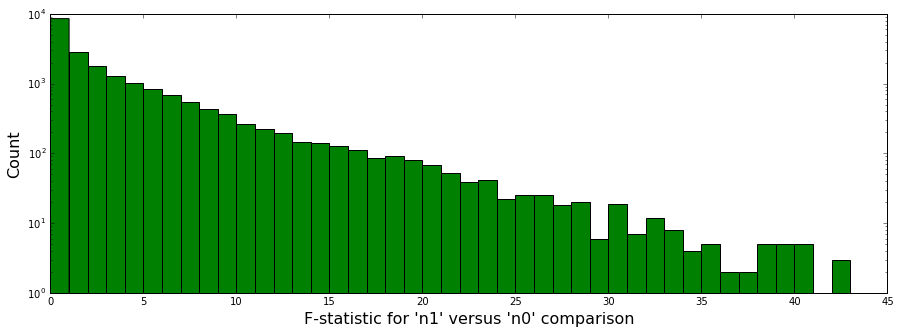

In [16]:
F_fig = plt.figure(figsize=(15,5))
A = F_fig.add_subplot(1,1,1)
A.hist(K_df['F_score'], bins=range(0,45,1), facecolor='green')
A.set_yscale('log')
A.set_ylabel('Count', fontsize=16)
A.set_xlabel("F-statistic for 'n1' versus 'n0' comparison", fontsize=16)
plt.show

In [17]:
"""Utilize the """
F_threshold = 5
F_best = list(K_df[K_df['F_score'] > F_threshold]['Gene']) #Genes in which an F-score less than 10 are filtered out

X_k = X.loc[:,F_best]
print("New Dataset, X_k, has shape:",X_k.shape)

F_threshold = 25
F_best = list(K_df[K_df['F_score'] > F_threshold]['Gene']) #Genes in which an F-score less than 10 are filtered out

X_kk = X.loc[:,F_best]
print("New Dataset, X_kk, has shape:",X_kk.shape)



New Dataset, X_k, has shape: (424, 4711)
New Dataset, X_kk, has shape: (424, 175)


## Generate Models

### Test Train Split

In [18]:
"""Scorers needed throughout code:"""
from sklearn.metrics import make_scorer
matthews_cor_scorer = make_scorer(matthews_corrcoef, greater_is_better=True, needs_proba=False, needs_threshold=False)
fbeta_scorer = make_scorer(fbeta_score, greater_is_better=True, needs_proba=False, needs_threshold=False, pos_label='n1', beta = 2)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [20]:
train_k = round(len(y)*4 /5) #2/3 of set dedicated to training set
test_k = len(y) - train_k #1/3 of set dedicated to test set

In [21]:
seed = 12
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size= test_k, 
                                                    train_size = train_k,
                                                    random_state = seed,
                                                    stratify = y)

### Support Vector Machine (SVM)

In [22]:
from sklearn.svm import SVC
svm_clf = SVC(C=1,
          kernel='linear',
          probability=False,
          tol=0.01,
          cache_size=200,
          gamma = 'auto',
          class_weight='balanced',
          verbose=False,
          max_iter=-1,
          random_state= 123)

#### Forward Feature Selection Wrapping Function

In [23]:
def wrapper(clf, X, y, max_features, show_max, steps_down, gain_tolerance) :
    feature_remaining = list(X.columns.values)
    row_list = []
    k_features = []
    test_features = []
    for it in range(0,max_features,1) :
        if steps_down == 0 :
            break
        else :
            feature_scores_dict = {}
            feature_sd_dict = {}
            for feature in feature_remaining :
                test_features.append(feature)
                clf.fit(X.loc[:,test_features], y)
                cv_scores = cross_val_score(clf, X.loc[:,test_features], y, scoring = fbeta_scorer, cv = 4)
                feature_scores_dict.update({tuple(test_features) : np.mean(cv_scores)})
                feature_sd_dict.update({tuple(test_features) : np.std(cv_scores)})
                test_features.remove(test_features[-1])        
            k_features.append(max(feature_scores_dict.keys(), key=(lambda k: feature_scores_dict[k]))[-1])
            test_features.append(max(feature_scores_dict.keys(), key=(lambda k: feature_scores_dict[k]))[-1])
            feature_remaining.remove(max(feature_scores_dict.keys(), key=(lambda k: feature_scores_dict[k]))[-1])
            dict1 = {'n_features': len(k_features),
                     'F2_score': feature_scores_dict.get(tuple(k_features)), 
                     'F2_SD' : feature_sd_dict.get(tuple(k_features)),
                     'Features': list(k_features)}
            row_list.append(dict1)
            print('Iteration: ',it+1,' complete!')
            
            """Does F2 increase?"""
            #print(row_list[-1])
            if it > 0 :
                gain = row_list[-1].get('F2_score') - row_list[-2].get('F2_score')
                print("F2 Score Gain:",gain)
                if gain < gain_tolerance :
                    steps_down -= 1
    
    """Benchmark for all features used"""
    if show_max == True :
        clf.fit(X,y)
        cv_scores = cross_val_score(clf, X, y, scoring = fbeta_scorer, cv = 5)
        dict1 = {'n_features': X.shape[1],
                 'F2_score': np.mean(cv_scores), 
                 'F2_SD' : np.std(cv_scores),
                 'Features': ["ALL"]}
        row_list.append(dict1)
    DF = pd.DataFrame(row_list, columns=['n_features','F2_score','F2_SD','Features'])
    #print(DF.iloc[:,0:3])
    
    """Make Complexity Plot"""
    plt.figure(figsize=(10,10))
    plt.scatter(DF['n_features'], DF['F2_score'], color='black')
    plt.errorbar(DF['n_features'], DF['F2_score'], yerr=DF['F2_SD'])
    plt.xlabel('Number of features')
    plt.xlim(0, np.max(DF['n_features'])+1)
    plt.ylabel('Mean F2 Score (CV=5)')
    plt.title('Complexity Plot')
    plt.show()
    return(k_features, DF)
    

Iteration:  1  complete!
Iteration:  2  complete!
F2 Score Gain: 0.0352901918006
Iteration:  3  complete!
F2 Score Gain: 0.0125943606029
Iteration:  4  complete!
F2 Score Gain: 0.0243940681168
Iteration:  5  complete!
F2 Score Gain: 0.00929304764566


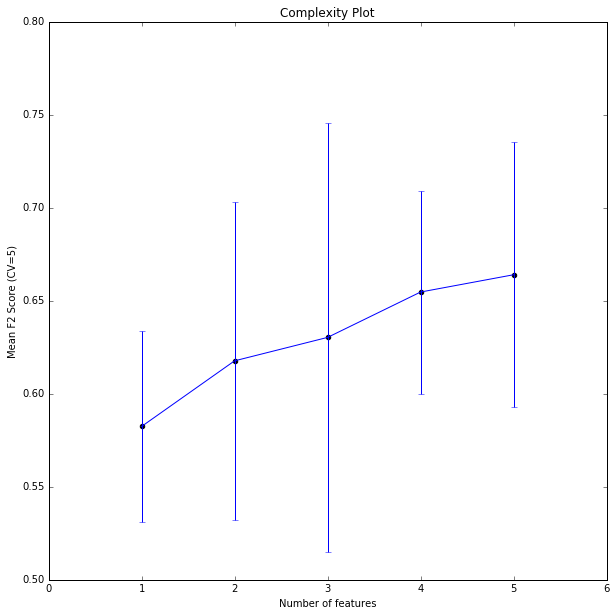

In [24]:
k_features, DF = wrapper(svm_clf, 
                         X_kk.loc[X_train.index], 
                         y_train, 
                         max_features= 10, 
                         show_max= False, 
                         steps_down=2, 
                         gain_tolerance = 0.02)

In [25]:
print(DF)

   n_features  F2_score     F2_SD                           Features
0           1  0.582434  0.051590                              [GNE]
1           2  0.617725  0.085573                       [GNE, CDKN3]
2           3  0.630319  0.115450                 [GNE, CDKN3, ADAR]
3           4  0.654713  0.054574          [GNE, CDKN3, ADAR, SPAG1]
4           5  0.664006  0.071261  [GNE, CDKN3, ADAR, SPAG1, INPP4A]


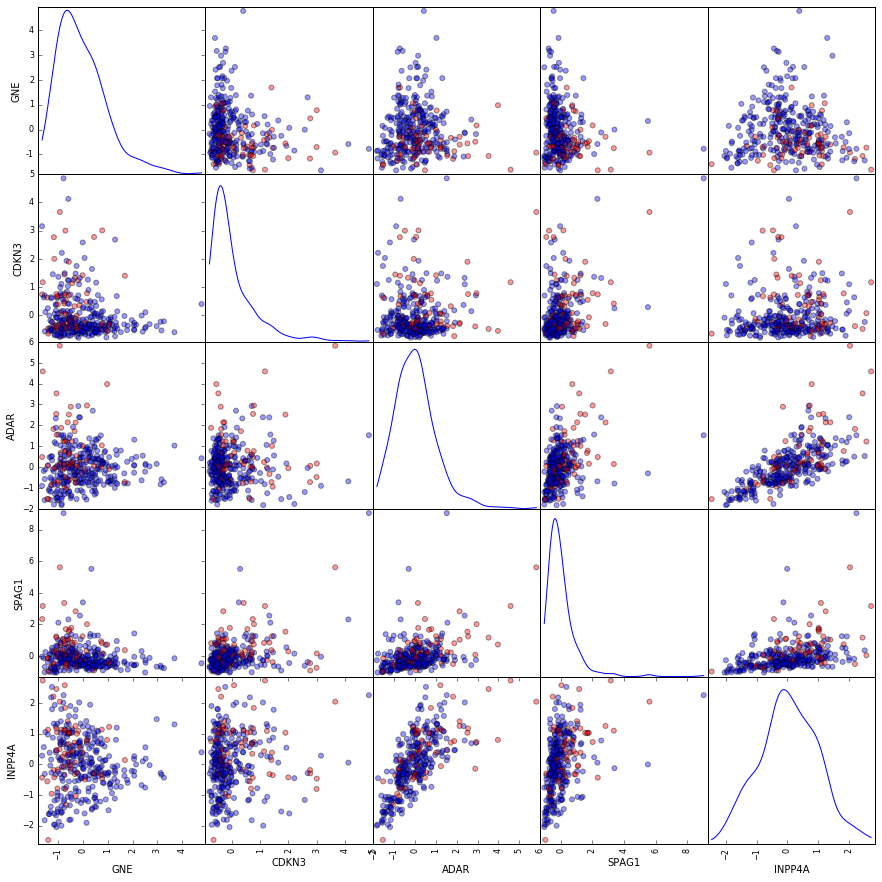

In [26]:
best_genes = DF.loc[(max(DF['n_features'])-1), 'Features'] 
#X_kk_f = X_train.loc[:,best_genes]
sm = pd.scatter_matrix(X_train.loc[:,best_genes], 
                       alpha=0.4, 
                       figsize= (15,15), 
                       diagonal = 'kde', 
                       c = y_train.replace({'n1': 'red','n0':'blue'}), 
                       s = 100)

### Univariate SVM Model Refinement

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
estimator = SVC(C=1,
                kernel='linear',
                probability=True,
                tol=0.001,
                cache_size=200,
                gamma = 'auto',
                class_weight='balanced',
                verbose=False,
                max_iter=-1,
                random_state= 123)

clf_search = GridSearchCV(estimator,
                   param_grid = {'kernel':['rbf','linear'],
                                 'C': [1,0.75, 0.5, 0.25, 0.1]},
                   scoring=fbeta_scorer,
                   fit_params=None,
                   n_jobs=1,
                   iid=True,
                   refit=True,
                   cv= 5,
                   verbose=0,
                   pre_dispatch='2*n_jobs',
                   error_score='raise')

In [29]:
clf_search.fit(X_train.loc[:,best_genes], y_train)
clf_svm_fr = clf_search.best_estimator_
print('\n',clf_svm_fr,'\n')
print(classification_report(y_train,
                            clf_svm_fr.predict(X_train.loc[:,best_genes]),
                            target_names = ['n0', 'n1']))
print('\nF beta: ', fbeta_score(y_train, clf_svm_fr.predict(X_train.loc[:,best_genes]), pos_label='n1',beta=2))
print('\nMCC: ',matthews_corrcoef(y_train, clf_svm_fr.predict(X_train.loc[:,best_genes])))


 SVC(C=0.25, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=123, shrinking=True,
  tol=0.001, verbose=False) 

             precision    recall  f1-score   support

         n0       0.94      0.74      0.83       276
         n1       0.41      0.79      0.54        63

avg / total       0.84      0.75      0.77       339


F beta:  0.666666666667

MCC:  0.428085762072


### Random Forest

In [30]:
%run -i Random_Forest/RF.py

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=20, min_samples_split=75,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False)

              precision    recall  f1-score   support

         n0       0.97      0.88      0.92       276
         n1       0.63      0.89      0.74        63

avg / total       0.91      0.88      0.89       339


F beta:  0.821114369501

MCC:  0.680093937782


### Logistic Regression

In [31]:
%run -i LogReg_gleason/LogReg_GS.py

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
             precision    recall  f1-score   support

         n0       0.93      0.62      0.74       276
         n1       0.32      0.81      0.46        63

avg / total       0.82      0.65      0.69       339


F beta:  0.623471882641

MCC:  0.331897507567


## Test for the best model

In [32]:
print(classification_report(y_test,
                            clf_svm_fr.predict(X_test.loc[:, best_genes]),
                            target_names = ['n0', 'n1']))
print('F beta: ', fbeta_score(y_test, clf_svm_fr.predict(X_test.loc[:, best_genes]), beta = 2, pos_label='n1'))
print('\nMCC: ',matthews_corrcoef(y_test, clf_svm_fr.predict(X_test.loc[:, best_genes])))

             precision    recall  f1-score   support

         n0       0.91      0.75      0.83        69
         n1       0.39      0.69      0.50        16

avg / total       0.81      0.74      0.76        85

F beta:  0.597826086957

MCC:  0.366883331481


In [33]:
print(classification_report(y_test,
                            RF_clf.predict(X_k.loc[X_test.index]),
                            target_names = ['n0', 'n1']))
print('F beta: ', fbeta_score(y_test, RF_clf.predict(X_k.loc[X_test.index]), beta = 2, pos_label='n1'))
print('\nMCC: ',matthews_corrcoef(y_test, RF_clf.predict(X_k.loc[X_test.index])))

             precision    recall  f1-score   support

         n0       0.89      0.86      0.87        69
         n1       0.47      0.56      0.51        16

avg / total       0.81      0.80      0.81        85

F beta:  0.542168674699

MCC:  0.391802876784


In [34]:
print(classification_report(y_test,
                            LR_clf.predict(logisticDF_test),
                            target_names = ['n0', 'n1']))
print('F beta: ', fbeta_score(y_test, LR_clf.predict(logisticDF_test), beta = 2, pos_label='n1'))
print('\nMCC: ',matthews_corrcoef(y_test, LR_clf.predict(logisticDF_test)))

             precision    recall  f1-score   support

         n0       0.96      0.70      0.81        69
         n1       0.40      0.88      0.55        16

avg / total       0.85      0.73      0.76        85

F beta:  0.707070707071

MCC:  0.453249139667


## Generate a Voting Classifier and Test for performance

In [35]:
clf_dict = {'SVM' : {'model': clf_svm_fr, 
                          'input_set': X_train.loc[:,best_genes], 
                          'label_set' : y_train, 
                          'weight' : 1}, 
            'Random_Forest' : {'model': RF_clf, 
                          'input_set': X_k.loc[X_train.index], 
                          'label_set' : y_train, 
                          'weight' : 1}, 
            'LogReg' : {'model': LR_clf, 
                          'input_set': logisticDF, 
                          'label_set' : y_train, 
                          'weight' : 1}}
test_dict = {'SVM' : {'model': clf_svm_fr, 
                          'input_set': X_test.loc[:,best_genes], 
                          'label_set' : y_test, 
                          'weight' : 1}, 
            'Random_Forest' : {'model': RF_clf, 
                          'input_set': X_k.loc[X_test.index], 
                          'label_set' : y_test, 
                          'weight' : 1}, 
            'LogReg' : {'model': LR_clf, 
                          'input_set': logisticDF_test, 
                          'label_set' : y_test, 
                          'weight' : 1}}

In [36]:

def voter(clf_dict, threshold=0.5, verbose = True) :
    """Test labels are in same order"""
    pass
    
    df = pd.DataFrame()
    weights = []
    for model in clf_dict.items() :
        if model[0] == 'PASS'  :
            df[model[0]] = model[1]['model'].predict(model[1]['input_set'])
            df[model[0]].replace({'n1':1,'n0':0}, inplace = True)
        else :
            df[model[0]] = model[1]['model'].predict_proba(model[1]['input_set'])[:,1]
        df[model[0]] = df[model[0]].apply(lambda x : x*model[1]['weight'])
        weights.append(model[1]['weight'])
    df.set_index(clf_dict['LogReg']['label_set'].index, inplace=True)
    #print(weights)
    df['Weighted_Vote'] = df.apply(lambda x : sum(x)/np.sum(weights), axis = 1)
    df['actual_y'] = list(clf_dict['LogReg']['label_set'])
    df['called_y'] = df['Weighted_Vote'].apply(lambda x : x >= threshold)
    df['called_y'] = df['called_y'].replace({False : 'n0', True : 'n1'})
    #print(df.tail(10)) #[Debug]
    if verbose == True :
        print('\nClass_report:\n ',classification_report(df['actual_y'], df['called_y']))
        print('\nF beta: ',fbeta_score(df['actual_y'], df['called_y'], beta = 2, pos_label='n1'))
        print('\nMCC: ',matthews_corrcoef(df['actual_y'], df['called_y']))
    return(fbeta_score(df['actual_y'], df['called_y'], beta = 2, pos_label='n1'),
           matthews_corrcoef(df['actual_y'], df['called_y']))


In [37]:
F2_train, MCC_train = voter(clf_dict, 0.5, verbose=True)


Class_report:
               precision    recall  f1-score   support

         n0       0.86      0.97      0.91       276
         n1       0.70      0.33      0.45        63

avg / total       0.83      0.85      0.83       339


F beta:  0.372340425532

MCC:  0.411864119469


In [38]:
"""Find appropriate voting threshold"""
#TH = pd.DataFrame(columns= ['Threshold', 'F2'])
temp_list = []
for x in np.arange(0.01, .99, 0.01) :
    temp_list.append({'Threshold': x, 'F2': voter(clf_dict, x, verbose=False)[0], 'MCC':voter(clf_dict, x, verbose=False)[1] })

Train_TH = pd.DataFrame(temp_list, columns = ['Threshold', 'F2', 'MCC'])

temp_list = []
for x in np.arange(0.01, .99, 0.02) :
    temp_list.append({'Threshold': x, 'F2': voter(test_dict, x, verbose=False)[0], 'MCC':voter(test_dict, x, verbose=False)[1] })

Test_TH = pd.DataFrame(temp_list, columns = ['Threshold', 'F2', 'MCC'])
    

/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<function matplotlib.pyplot.show>

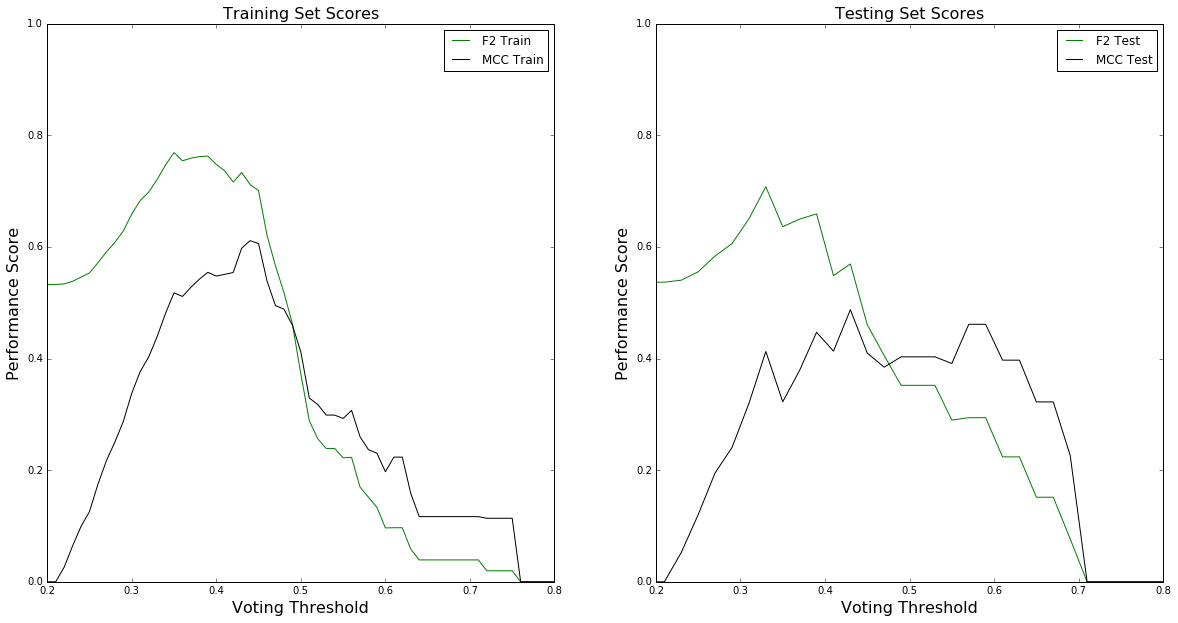

In [39]:
TH_fig = plt.figure(figsize=(20,10))
A = TH_fig.add_subplot(1,2,1)
B = TH_fig.add_subplot(1,2,2)
A.plot(Train_TH['Threshold'], Train_TH['F2'], color = 'green', label='F2 Train')
A.plot(Train_TH['Threshold'], Train_TH['MCC'], color = 'black', label = 'MCC Train')
B.plot(Test_TH['Threshold'], Test_TH['F2'], color = 'green', label = 'F2 Test')
B.plot(Test_TH['Threshold'], Test_TH['MCC'], color = 'black', label = 'MCC Test')
A.legend(loc='best')
B.legend()
A.set_ylim(0,1)
A.set_xlim(.2,.8)
B.set_ylim(0,1)
B.set_xlim(.2,.8)
A.set_title('Training Set Scores', fontsize=16)
B.set_title('Testing Set Scores', fontsize=16)
A.set_ylabel('Performance Score', fontsize=16)
B.set_ylabel('Performance Score', fontsize=16)
A.set_xlabel('Voting Threshold', fontsize=16)
B.set_xlabel('Voting Threshold', fontsize=16)
plt.show
    

In [40]:
F2, MCC = voter(test_dict, threshold=0.35, verbose=True)


Class_report:
               precision    recall  f1-score   support

         n0       0.95      0.54      0.69        69
         n1       0.30      0.88      0.45        16

avg / total       0.83      0.60      0.64        85


F beta:  0.636363636364

MCC:  0.322596830988


##### 